## RNN을 이용한 넷플릭스 주가 예측

In [30]:
import torch
import pandas as pd
import torch.nn as nn
import numpy as np
import tqdm
from torch.optim.adam import Adam
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
from torch.utils.data.dataset import Dataset

from model.rnn import RNN

#### 데이터 확인하기

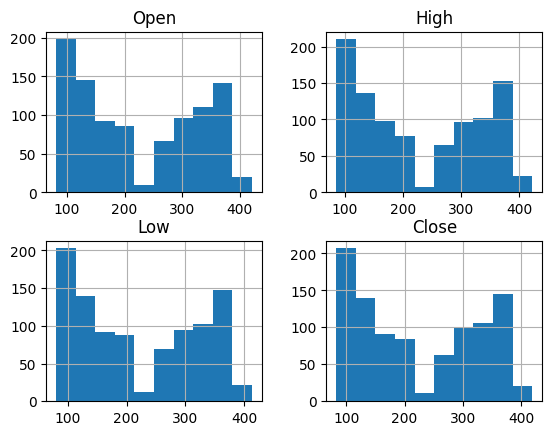

In [31]:
data = pd.read_csv("./data/rnn/netflix.csv", sep=",")

data_used = data.iloc[:, 1:4]
data_used["Close"] = data["Close"]
hist = data_used.hist()
plt.show()

#### utils

In [32]:
class Netflix(Dataset):
    def __init__(self):
        self.csv = pd.read_csv("./data/rnn/netflix.csv")

        self.data = self.csv.iloc[:, 1:4].values
        self.data = self.data / np.max(self.data)

        self.label = data["Close"].values
        self.label = self.label / np.max(self.label)

    def __len__(self):
        return len(self.data) - 30
    
    def __getitem__(self, i):
        data = self.data[i:i+30]
        label = self.label[i+30]

        return data, label

#### 학습

In [33]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = RNN().to(device)
dataset = Netflix()

loader = DataLoader(dataset, batch_size=32)
optim = Adam(params=model.parameters(), lr=0.0001)

for epoch in range(10):
    iterator = tqdm.tqdm(loader)
    for data, label in iterator:
        optim.zero_grad()

        h0 = torch.zeros(5, data.shape[0], 32).to(device)

        pred = model(data.type(torch.FloatTensor).to(device), h0)

        loss = nn.MSELoss()(pred, label.type(torch.FloatTensor).to(device))
        loss.backward()
        optim.step()

        iterator.set_description(f"epoch{epoch} loss:{loss.item()}")

torch.save(model.state_dict(), "./data/weights/rnn.pth")



epoch9 loss:0.013936423696577549: 100%|██████████| 30/30 [00:01<00:00, 26.91it/s]  


#### 평가

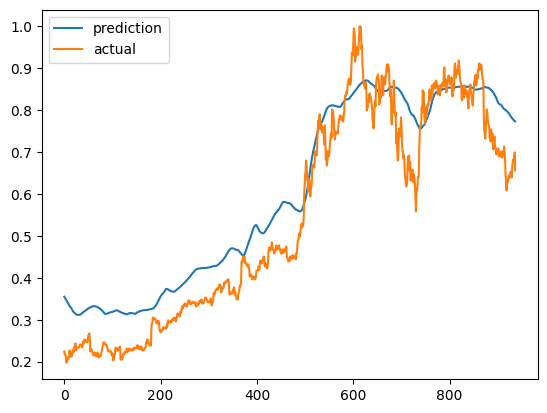

In [35]:
loader = DataLoader(dataset, batch_size=1)

preds = []
total_loss = 0

with torch.no_grad():
    model.load_state_dict(torch.load("./data/weights/rnn.pth", map_location=device))

    for data, label in loader:
        h0 = torch.zeros(5, data.shape[0], 32).to(device)

        pred = model(data.type(torch.FloatTensor).to(device), h0)
        preds.append(pred.item())
        loss = nn.MSELoss()(pred,label.type(torch.FloatTensor).to(device))
        total_loss += loss/len(loader)

total_loss.item()

plt.plot(preds, label="prediction")
plt.plot(dataset.label[30:], label="actual")
plt.legend()
plt.show()